# Iterative Workflows and Deep Provenance Chains

This notebook demonstrates how Consist tracks provenance through an **iterative equilibrium model**—a common pattern in transportation, economics, and agent-based simulation where outputs feed back as inputs until the system converges.

## What you'll learn

- How Consist tracks multi-step iterative workflows
- How to skip redundant computation when extending a run
- How to query artifact lineage to understand what produced a result

## Notebook Goals

By the end of this notebook, you'll understand how to:
- Structure an iterative workflow with scenarios and the coupler
- Reuse cached iterations when you extend or tweak a scenario
- Inspect lineage to trace outputs back through the computational graph

## The Model

We simulate morning commute mode choice in a stylized 5-zone linear city:

```
Zone 1 ←→ Zone 2 ←→ Zone 3 ←→ Zone 4 ←→ Zone 5
(Low)     (Med)     (High/CBD)  (Med)     (Low)
```

**Feedback loop:**
1. **Logsums**: Compute accessibility from current travel times
2. **Trip Distribution**: Workers choose job locations based on accessibility
3. **Mode Choice**: Each commuter chooses car, transit, or walk
4. **Assignment**: Car trips create congestion
5. **Skim Update**: Congestion slows travel times → back to step 1

The model iterates until mode shares stabilize.

## Provenance Value

This structure lets us answer questions like:
- "Which iteration's skims were used to produce this trip table?"
- "If I change parking costs, which steps need to re-run?"
- "Can I resume from iteration 7 with a tighter convergence threshold?"


In [1]:
from __future__ import annotations

import sys
from pathlib import Path


def _find_repo_root(start: Path) -> Path:
    for candidate in (start, *start.parents):
        if (candidate / "pyproject.toml").exists():
            return candidate
    raise RuntimeError("Could not locate repo root (missing pyproject.toml)")


REPO_ROOT = _find_repo_root(Path.cwd())
EXAMPLES_DIR = REPO_ROOT / "examples"
EXAMPLES_SRC = EXAMPLES_DIR / "src"

for path in (REPO_ROOT, EXAMPLES_SRC):
    if str(path) not in sys.path:
        sys.path.insert(0, str(path))

In [2]:
from dataclasses import asdict, replace

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from tqdm import tqdm

import consist
from consist import Tracker

from travel_demand_functions import (
    AssignmentParams,
    DestinationChoiceParams,
    ModeChoiceParams,
    TravelDemandScenarioConfig,
    ZoneParams,
    apply_congestion,
    apply_mode_choice,
    compute_mode_shares,
    compute_mode_utilities,
    compute_od_logsums,
    compute_od_volumes,
    create_skims_dataset,
    distribute_trips,
    generate_distances,
    generate_population,
    generate_zones,
    save_skims,
    skims_to_dataframe,
    summarize_iteration,
)

sns.set_theme(style="whitegrid")

## Workflow Functions and Instrumentation Choices

This notebook uses both `run(...)` and `trace(...)` patterns. For when to use each, see the [Concepts Overview](../docs/concepts.md#when-to-use-each-pattern) and the [Usage Guide](../docs/usage-guide.md).


## Setup

We initialize the tracker and import our model functions. Each run gets a unique session ID so we can compare multiple runs in the same database.

In [3]:
EXAMPLES_DIR = REPO_ROOT / "examples"
RUN_DIR = EXAMPLES_DIR / "runs" / "travel_demand_demo"
SESSION_ID = os.getenv("CONSIST_SESSION_ID", "demo")
DB_PATH = RUN_DIR / f"travel_demand_demo_{SESSION_ID}.duckdb"
if DB_PATH.exists():
    DB_PATH.unlink()

tracker = Tracker(
    run_dir=RUN_DIR,
    db_path=DB_PATH,
    hashing_strategy="fast",
    project_root=str(RUN_DIR),
)

[SQL: ALTER TABLE run DROP CONSTRAINT IF EXISTS fk_run_parent]
(Background on this error at: https://sqlalche.me/e/20/tw8g)


## Model Configuration

The model has four parameter groups:

| Parameter Group           | Controls                                                     |
|---------------------------|--------------------------------------------------------------|
| `ZoneParams`              | City layout: population, jobs, parking costs, transit access |
| `ModeChoiceParams`        | Utility coefficients, speeds, costs                          |
| `DestinationChoiceParams` | How accessibility affects job location choice                |
| `AssignmentParams`        | BPR congestion function parameters                           |

**ZoneParams** defines the city structure. The central zone (Zone 3) has the most jobs and highest parking costs, mimicking a downtown CBD. Outer zones are residential with cheaper or free parking.

**ModeChoiceParams** sets the coefficients for a standard multinomial logit mode choice model. `beta_cost` and `beta_time` control sensitivity to travel cost and time; the ASCs (alternative-specific constants) capture baseline preferences for transit and walking relative to driving.

**DestinationChoiceParams** governs how workers choose job locations. `beta_access` weights the logsum (a measure of how easy it is to reach a zone by any mode), while `beta_size` weights employment size.

**AssignmentParams** controls the BPR (Bureau of Public Roads) volume-delay function that converts traffic volumes into congested travel times.

We also set two equilibrium parameters:
- `SKIM_PERTURBATION`: Initial congestion multiplier (starts the system away from equilibrium so we can watch it converge)
- `DESTINATION_UPDATE_SHARE`: Damping factor for stability (blend new destination choices with previous iteration to prevent oscillation)

In [4]:
zone_params = ZoneParams()
mode_params = ModeChoiceParams()
dest_params = DestinationChoiceParams()
assignment_params = AssignmentParams()

DEFAULT_SEED = 0

base_config = TravelDemandScenarioConfig(
    n_iterations=10,
    seed=DEFAULT_SEED,
    zone_params=zone_params,
    mode_params=mode_params,
    dest_params=dest_params,
    assignment_params=assignment_params,
)

SCENARIO_NAME = "travel_demand_demo"

SKIM_PERTURBATION = 0.1
DESTINATION_UPDATE_SHARE = 0.2

## Baseline Scenario

We run the equilibrium loop, tracking each step's inputs and outputs. The coupler passes artifacts between steps within the scenario—when we update `skims` after traffic simulation, the next iteration's logsum calculation automatically picks up the congested version.

### Step Structure per Iteration

```
┌─────────────┐
│    init     │ (iteration 0 only)
└──────┬──────┘
       │ skims, zones, population
       ▼
┌─────────────┐
│   logsums   │◄─── skims, zones
└──────┬──────┘
       │ logsums
       ▼
┌─────────────┐
│ trip_dist   │◄─── logsums, zones, population
└──────┬──────┘
       │ trips
       ▼
┌─────────────┐
│ utilities   │◄─── trips, skims, zones
└──────┬──────┘
       │ utilities
       ▼
┌─────────────┐
│ mode_choice │◄─── utilities, (prev trips_with_modes)
└──────┬──────┘
       │ trips_with_modes
       ▼
┌─────────────┐
│ assignment  │◄─── trips_with_modes
└──────┬──────┘
       │ volumes
       ▼
┌─────────────┐
│ traffic_sim │◄─── volumes, skims
└──────┬──────┘
       │ updated skims ──► next iteration
       ▼
```

### `run(...)` vs `trace(...)`

For a concise explanation, see the [Concepts Overview](../docs/concepts.md#when-to-use-each-pattern).


### Simplified run loop (shape only)

Below is a compact outline of the iterative loop. The full implementation (with logging and plotting) follows.

```python
def run_scenario(scenario_config, scenario_run_id):
    with tracker.scenario(scenario_run_id, config=..., tags=[...]) as scenario:
        scenario.run(name="init", fn=initialize_scenario, ...)
        for i in range(scenario_config.n_iterations):
            with scenario.trace(name="logsums", ...):
                ...
            scenario.run(name="trip_distribution", ...)
            scenario.run(name="calculate_utilities", ...)
            scenario.run(name="mode_choice", ...)
            scenario.run(name="assignment", ...)
            scenario.run(name="traffic_simulation", ...)
        scenario.run(name="summaries", ...)
    return results
```


In [5]:
@tracker.define_step(outputs=["skims", "persons", "zones"])
def initialize_scenario(*, zone_params, mode_params, skim_perturbation, _consist_ctx):
    zones = generate_zones(zone_params)
    population = generate_population(zones)
    distances = generate_distances(zone_params)

    skims = create_skims_dataset(zones, distances, mode_params)
    skims["time_car_mins"] *= skim_perturbation

    output_dir = _consist_ctx.run_dir
    output_dir.mkdir(parents=True, exist_ok=True)
    input_skims_path = output_dir / "skims_init.zarr"

    save_skims(skims, input_skims_path)

    consist.log_artifact(input_skims_path, key="skims", direction="output")
    consist.log_dataframe(
        population,
        key="persons",
        direction="output",
    )
    consist.log_dataframe(zones, key="zones", direction="output")


@tracker.define_step(outputs=["trips"])
def distribute_trips_step(*, dest_params, seed, update_share, _consist_ctx):
    zones = _consist_ctx.load("zones")
    population = _consist_ctx.load("persons")
    prev_trips_art = _consist_ctx.inputs.get("trips")
    prev_trips = _consist_ctx.load(prev_trips_art) if prev_trips_art else None
    logsums_df = _consist_ctx.load("logsums")
    if "origin" not in logsums_df.columns or "destination" not in logsums_df.columns:
        logsums_df = logsums_df.reset_index()
    logsums = logsums_df.set_index(["origin", "destination"])["logsum"].to_xarray()
    trips = distribute_trips(
        population,
        zones,
        logsums,
        dest_params,
        seed=seed,
        prev_trips=prev_trips,
        update_share=update_share,
    )
    consist.log_dataframe(trips, key="trips")


@tracker.define_step(
    outputs=[
        "mode_shares",
        "iteration_summaries",
        "pmt_totals",
        "mode_shares_plot",
        "iteration_totals_plot",
    ]
)
def summarize_results_step(*, mode_shares, summaries, pmt_totals, _consist_ctx):
    output_dir = _consist_ctx.run_dir
    summary_dir = output_dir / "summary"
    summary_dir.mkdir(parents=True, exist_ok=True)

    mode_shares_df = (
        pd.DataFrame.from_dict(mode_shares, orient="index")
        .sort_index()
        .rename_axis("iteration")
        .reset_index()
    )
    summaries_df = (
        pd.DataFrame.from_dict(summaries, orient="index")
        .sort_values("iteration")
        .reset_index(drop=True)
    )
    pmt_totals_df = (
        pd.DataFrame.from_dict(pmt_totals, orient="index")
        .sort_index()
        .rename_axis("iteration")
        .reset_index()
    )

    mode_shares_path = summary_dir / "mode_shares.csv"
    summaries_path = summary_dir / "iteration_summaries.csv"
    pmt_totals_path = summary_dir / "pmt_totals.csv"

    shares_long = mode_shares_df.melt(
        id_vars="iteration", var_name="mode", value_name="share"
    )
    plt.figure(figsize=(8, 4))
    sns.lineplot(data=shares_long, x="iteration", y="share", hue="mode", marker="o")
    plt.title("Mode Shares by Iteration")
    plt.tight_layout()
    mode_share_plot_path = summary_dir / "mode_shares.png"
    plt.savefig(mode_share_plot_path)
    plt.close()

    pmt_long = pmt_totals_df.melt(
        id_vars="iteration", var_name="mode", value_name="pmt"
    )
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.lineplot(data=summaries_df, x="iteration", y="vmt", marker="o", ax=axes[0])
    axes[0].set_title("Vehicle Miles Traveled")
    sns.lineplot(
        data=pmt_long,
        x="iteration",
        y="pmt",
        hue="mode",
        marker="o",
        ax=axes[1],
    )
    axes[1].set_title("Person Miles Traveled by Mode")
    fig.tight_layout()
    totals_plot_path = summary_dir / "iteration_totals.png"
    fig.savefig(totals_plot_path)
    plt.close(fig)

    consist.log_dataframe(
        mode_shares_df,
        key="mode_shares",
        path=mode_shares_path,
    )
    consist.log_dataframe(
        summaries_df,
        key="iteration_summaries",
        path=summaries_path,
    )
    consist.log_dataframe(
        pmt_totals_df,
        key="pmt_totals",
        path=pmt_totals_path,
    )
    consist.log_artifact(
        mode_share_plot_path,
        key="mode_shares_plot",
        direction="output",
    )
    consist.log_artifact(
        totals_plot_path,
        key="iteration_totals_plot",
        direction="output",
    )


def run_scenario(scenario_config, scenario_run_id):
    mode_shares = {}
    summaries = {}
    pmt_totals = {}

    zone_params = scenario_config.zone_params
    mode_params = scenario_config.mode_params
    dest_params = scenario_config.dest_params
    assignment_params = scenario_config.assignment_params
    seed = scenario_config.seed

    with tracker.scenario(
        scenario_run_id,
        config={
            **asdict(scenario_config),
            "scenario_name": SCENARIO_NAME,
        },
        facet_from=["n_iterations"],
        tags=["examples", "simulation", "travel_demand"],
    ) as scenario:
        cache_validation = "lazy"  # Skip output checks on cache hits for speed; use 'eager' to validate files.
        cache_hydration = (
            "inputs-missing"  # Copy cached inputs into the new run_dir on cache misses.
        )

        scenario.run(
            name="init",
            fn=initialize_scenario,
            config=asdict(mode_params)
            | asdict(zone_params)
            | {"skim_perturbation": SKIM_PERTURBATION},
            facet_from=["skim_perturbation"],
            inject_context=True,
            fn_args={
                "zone_params": zone_params,
                "mode_params": mode_params,
                "skim_perturbation": SKIM_PERTURBATION,
            },
        )

        for i in tqdm(range(scenario_config.n_iterations)):
            # Inline trace pattern (no wrapper function required).
            with scenario.trace(
                name="logsums",
                run_id=f"{scenario.run_id}_logsums_{i}",
                config=asdict(mode_params),
                inputs={"skims": "skims", "zones": "zones"},
                facet_from=[
                    "beta_cost",
                    "beta_time",
                    "asc_walk",
                    "asc_transit",
                    "fuel_cost_per_mile",
                    "transit_fare",
                ],
                validate_cached_outputs=cache_validation,
                cache_hydration=cache_hydration,
                iteration=i,
            ) as t:
                if not t.is_cached:
                    logsums = compute_od_logsums(
                        t.load(scenario.coupler.require("skims")),
                        t.load(scenario.coupler.require("zones")),
                        mode_params,
                    )
                    consist.log_dataframe(
                        logsums.to_dataframe().reset_index(),
                        key="logsums",
                    )

            scenario.run(
                name="trip_distribution",
                fn=distribute_trips_step,
                run_id=f"{scenario.run_id}_trip_distribution_{i}",
                config={
                    **asdict(dest_params),
                    "update_share": DESTINATION_UPDATE_SHARE,
                },
                inputs={
                    "skims": "skims",
                    "zones": "zones",
                    "persons": "persons",
                    "logsums": "logsums",
                },
                optional_input_keys=["trips"],
                facet_from=["beta_size", "beta_access", "update_share"],
                inject_context=True,
                fn_args={
                    "dest_params": dest_params,
                    "seed": seed + i,
                    "update_share": DESTINATION_UPDATE_SHARE,
                },
                iteration=i,
            )

            # `load_inputs=True` hydrates artifacts into function args by name.
            scenario.run(
                name="calculate_utilities",
                fn=compute_mode_utilities,
                run_id=f"{scenario.run_id}_utilities_{i}",
                config=asdict(mode_params),
                inputs={"trips": "trips", "skims": "skims", "zones": "zones"},
                facet_from=[
                    "beta_cost",
                    "beta_time",
                    "asc_walk",
                    "asc_transit",
                ],
                validate_cached_outputs=cache_validation,
                cache_hydration=cache_hydration,
                load_inputs=True,
                fn_args={"mode_params": mode_params},
                outputs=["utilities"],
                iteration=i,
            )

            mode_choice_result = scenario.run(
                name="mode_choice",
                fn=apply_mode_choice,
                run_id=f"{scenario.run_id}_mode_choice_{i}",
                config={"seed": seed},
                inputs={"utilities_df": "utilities"},
                fn_args={"seed": seed + i},
                outputs=["trips_with_modes"],
                iteration=i,
            )

            scenario.run(
                name="assignment",
                fn=compute_od_volumes,
                run_id=f"{scenario.run_id}_assignment_{i}",
                inputs={"trips": "trips_with_modes"},
                outputs=["volumes"],
                iteration=i,
            )

            scenario.run(
                name="traffic_simulation",
                fn=apply_congestion,
                run_id=f"{scenario.run_id}_traffic_simulation_{i}",
                config=asdict(assignment_params),
                inputs={"volumes": "volumes", "skims": "skims"},
                facet_from=["bpr_alpha", "bpr_beta", "base_capacity"],
                fn_args={"assignment_params": assignment_params},
                outputs=["skims"],
                iteration=i,
            )

            trips_with_modes = tracker.load(
                mode_choice_result.outputs["trips_with_modes"]
            )
            shares = compute_mode_shares(trips_with_modes)
            mode_shares[i] = pd.Series(shares)
            distance_by_mode = trips_with_modes.groupby("mode")["distance_miles"].sum()
            pmt_totals[i] = distance_by_mode.sort_index()
            summaries[i] = summarize_iteration(i, trips_with_modes, shares, 0, False)

        summary_result = scenario.run(
            name="summaries",
            fn=summarize_results_step,
            inputs={"trips_with_modes": "trips_with_modes"},
            inject_context=True,
            validate_cached_outputs=cache_validation,
            cache_hydration=cache_hydration,
            fn_args={
                "mode_shares": mode_shares,
                "summaries": summaries,
                "pmt_totals": pmt_totals,
            },
        )

        mode_shares_df = tracker.load(summary_result.outputs["mode_shares"])
        summaries_df = tracker.load(summary_result.outputs["iteration_summaries"])
        pmt_totals_df = tracker.load(summary_result.outputs["pmt_totals"])
        mode_share_plot_path = Path(
            tracker.resolve_uri(summary_result.outputs["mode_shares_plot"].uri)
        )
        totals_plot_path = Path(
            tracker.resolve_uri(summary_result.outputs["iteration_totals_plot"].uri)
        )

    return {
        "scenario_run_id": scenario_run_id,
        "mode_shares_df": mode_shares_df,
        "summaries_df": summaries_df,
        "pmt_totals_df": pmt_totals_df,
        "mode_share_plot_path": mode_share_plot_path,
        "totals_plot_path": totals_plot_path,
    }

In [6]:
base_run_id = f"{SCENARIO_NAME}_{SESSION_ID}"
base_results = run_scenario(base_config, base_run_id)

analysis = base_results

mode_shares_df = analysis["mode_shares_df"]
summaries_df = analysis["summaries_df"]
pmt_totals_df = analysis["pmt_totals_df"]
mode_share_plot_path = analysis["mode_share_plot_path"]
totals_plot_path = analysis["totals_plot_path"]
SCENARIO_RUN_ID = analysis["scenario_run_id"]

100%|██████████| 10/10 [00:23<00:00,  2.37s/it]


## Artifact Lineage (preview)

The lineage tree shows how the final `skims` artifact traces back through the computational graph. Reading the tree:

- Each **artifact** (like `skims`, `volumes`) shows its key and unique ID
- Below each artifact is the **run** that produced it, with the step name, run ID, and iteration number
- Indented below each run are its **input artifacts**, which recursively show their own producers

This forms a DAG (directed acyclic graph) where you can trace any output back to the original inputs. With `max_depth=4`, we see four levels of this chain—in a 10-iteration model, the full lineage would be much deeper.

In [7]:
from rich import print as rprint
from rich.tree import Tree


def _add_lineage(branch, node):
    artifact = node["artifact"]
    art_label = f"{artifact.key} ({artifact.id})"
    art_branch = branch.add(art_label)
    run_node = node.get("producing_run")
    if not run_node:
        return
    run = run_node["run"]
    run_label = f"{run.model_name} run={run.id} iter={run.iteration}"
    run_branch = art_branch.add(run_label)
    for child in run_node.get("inputs", []):
        _add_lineage(run_branch, child)


final_skims = tracker.get_artifact("skims")
lineage = (
    tracker.get_artifact_lineage(final_skims.id, max_depth=4) if final_skims else None
)

if lineage:
    tree = Tree("lineage")
    _add_lineage(tree, lineage)
    rprint(tree)

lineage
└── skims (85ce4fff-9aa4-430b-83d8-fd5ba4f84515)
    └── traffic_simulation run=travel_demand_demo_demo_traffic_simulation_9 iter=9
        ├── skims (7e79f43a-2a8a-4647-bd4a-727a84fa3a00)
        │   └── traffic_simulation run=travel_demand_demo_demo_traffic_simulation_8 iter=8
        │       ├── skims (5576f58b-30ba-4597-8a58-53d28030d394)
        │       │   └── traffic_simulation run=travel_demand_demo_demo_traffic_simulation_7 iter=7
        │       │       ├── skims (49bd75da-2594-4bff-8130-7e17fb87be3e)
        │       │       │   └── traffic_simulation run=travel_demand_demo_demo_traffic_simulation_6 iter=6
        │       │       │       ├── skims (9bc0d3aa-0d02-46fb-b1fb-14bb46fe199c)
        │       │       │       └── volumes (862dee22-d4b2-4475-8e51-1d89945cdbc4)
        │       │       └── volumes (b71e83cf-7480-4403-8d2a-db0bc4be6a71)
        │       │           └── assignment run=travel_demand_demo_demo_assignment_7 iter=7
        │       │               └── trips_with_modes (72e745c3-dfd3-4393-ae00-5a01f35b6149)
        │       └── volumes (47ed948b-d7f6-4ea8-a25b-f22dbd5213d1)
        │           └── assignment run=travel_demand_demo_demo_assignment_8 iter=8
        │               └── trips_with_modes (35ee099b-be1c-4af4-a414-7b4c78f0b708)
        │                   └── mode_choice run=travel_demand_demo_demo_mode_choice_8 iter=8
        │                       └── utilities (58b21be8-eb9a-4938-931a-6d97b0cb2ae8)
        └── volumes (ab95eeda-1fd3-46b3-897c-6fec7eca8652)
            └── assignment run=travel_demand_demo_demo_assignment_9 iter=9
                └── trips_with_modes (6c11b602-c83e-49eb-9276-39bc15b64c1e)
                    └── mode_choice run=travel_demand_demo_demo_mode_choice_9 iter=9
                        └── utilities (294cfb08-4bfe-4f7d-aec7-0e5f6bde4428)
                            └── calculate_utilities run=travel_demand_demo_demo_utilities_9 iter=9
                                ├── zones (da6dbf64-676a-4a6d-bd86-0400fc14e1f2)
                                ├── skims (7e79f43a-2a8a-4647-bd4a-727a84fa3a00)
                                └── trips (ee736fed-729c-425e-a743-a78ffa92058c)

## Scenario Comparison: Higher Parking Costs

Now let's run a second scenario with higher CBD parking costs and compare the outcomes tothe baseline run. We'll focus on final-iteration mode shares, person-miles traveled, andcore summary metrics.


In [8]:
high_parking_config = replace(
    base_config,
    zone_params=ZoneParams(parking_costs=(0.0, 8.0, 25.0, 8.0, 0.0)),
)
high_parking_run_id = f"{SCENARIO_NAME}_{SESSION_ID}_high_parking"
high_parking_results = run_scenario(high_parking_config, high_parking_run_id)

final_iteration = base_results["summaries_df"]["iteration"].max()

base_shares = base_results["mode_shares_df"].set_index("iteration").loc[final_iteration]
hp_shares = (
    high_parking_results["mode_shares_df"].set_index("iteration").loc[final_iteration]
)
mode_share_comparison = pd.DataFrame(
    {
        "base": base_shares,
        "high_parking": hp_shares,
    }
)
mode_share_comparison["delta"] = (
    mode_share_comparison["high_parking"] - mode_share_comparison["base"]
)

base_pmt = base_results["pmt_totals_df"].set_index("iteration").loc[final_iteration]
hp_pmt = (
    high_parking_results["pmt_totals_df"].set_index("iteration").loc[final_iteration]
)
pmt_comparison = pd.DataFrame(
    {
        "base": base_pmt,
        "high_parking": hp_pmt,
    }
)
pmt_comparison["delta"] = pmt_comparison["high_parking"] - pmt_comparison["base"]

summary_cols = ["vmt", "total_trips", "car_share", "transit_share", "walk_share"]
base_summary = (
    base_results["summaries_df"]
    .set_index("iteration")
    .loc[final_iteration, summary_cols]
)
hp_summary = (
    high_parking_results["summaries_df"]
    .set_index("iteration")
    .loc[final_iteration, summary_cols]
)
summary_comparison = pd.DataFrame(
    {
        "base": base_summary,
        "high_parking": hp_summary,
    }
)
summary_comparison["delta"] = (
    summary_comparison["high_parking"] - summary_comparison["base"]
)

display(mode_share_comparison)
display(pmt_comparison)
display(summary_comparison)

100%|██████████| 10/10 [00:41<00:00,  4.19s/it]


,base,high_parking,delta
car,0.5136,0.4724,-0.0412
transit,0.3105,0.3345,0.0240
walk,0.1759,0.1931,0.0172


,base,high_parking,delta
car,14997.0,14409.0,-588.0
transit,7666.0,8190.0,524.0
walk,2253.0,2525.0,272.0


,base,high_parking,delta
vmt,14997.0,14409.0,-588.0
total_trips,10000,10000,0
car_share,0.5136,0.4724,-0.0412
transit_share,0.3105,0.3345,0.024
walk_share,0.1759,0.1931,0.0172


## Convergence Results

Let's examine how mode shares evolved across iterations. In a well-tuned model, shares should
stabilize as the feedback between congestion and mode choice reaches equilibrium.


In [9]:
mode_shares_df

,iteration,car,transit,walk
0,0,0.6505,0.2246,0.1249
1,1,0.4343,0.3638,0.2019
2,2,0.5476,0.2833,0.1691
3,3,0.5063,0.3105,0.1832
4,4,0.5137,0.3046,0.1817
5,5,0.5095,0.3079,0.1826
6,6,0.5138,0.3128,0.1734
7,7,0.5129,0.3072,0.1799
8,8,0.5123,0.3024,0.1853
9,9,0.5136,0.3105,0.1759


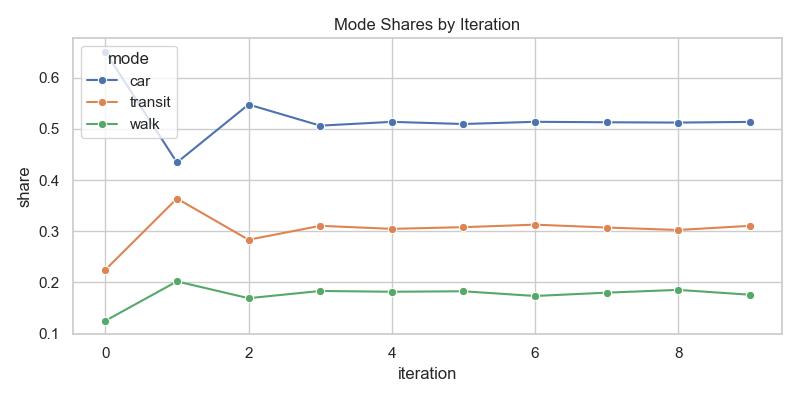

In [10]:
from IPython.display import Image

Image(filename=str(mode_share_plot_path))

## Incremental Computation Demo

We ran the baseline scenario for 10 iterations above. Now we'll run an extended scenario for15 iterations. Since the extended run shares the same parameters for iterations 0-9, Consistshould recognize those steps have already been computed and skip them—only running iterations 10through 14.


In [11]:
import os

os.environ["CONSIST_CACHE_DEBUG"] = (
    "1"  # Log cache hits/misses during the incremental run.
)
extended_config = replace(base_config, n_iterations=15)
extended_run_id = f"{SCENARIO_NAME}_{SESSION_ID}_extended"
extended_results = run_scenario(extended_config, extended_run_id)

100%|██████████| 15/15 [01:21<00:00,  5.40s/it]


In [12]:
# Quick cache-hit check for the extended run.
cached_runs = [
    run
    for run in tracker.find_runs(parent_id=extended_results["scenario_run_id"])
    if run.meta.get("cache_hit")
]
[(run.model_name, run.iteration, run.id) for run in cached_runs]

[('traffic_simulation',
  9,
  'travel_demand_demo_demo_extended_traffic_simulation_9'),
 ('assignment', 9, 'travel_demand_demo_demo_extended_assignment_9'),
 ('mode_choice', 9, 'travel_demand_demo_demo_extended_mode_choice_9'),
 ('calculate_utilities', 9, 'travel_demand_demo_demo_extended_utilities_9'),
 ('trip_distribution',
  9,
  'travel_demand_demo_demo_extended_trip_distribution_9'),
 ('logsums', 9, 'travel_demand_demo_demo_extended_logsums_9'),
 ('traffic_simulation',
  8,
  'travel_demand_demo_demo_extended_traffic_simulation_8'),
 ('assignment', 8, 'travel_demand_demo_demo_extended_assignment_8'),
 ('mode_choice', 8, 'travel_demand_demo_demo_extended_mode_choice_8'),
 ('calculate_utilities', 8, 'travel_demand_demo_demo_extended_utilities_8'),
 ('trip_distribution',
  8,
  'travel_demand_demo_demo_extended_trip_distribution_8'),
 ('logsums', 8, 'travel_demand_demo_demo_extended_logsums_8'),
 ('traffic_simulation',
  7,
  'travel_demand_demo_demo_extended_traffic_simulation_7'),

As expected, all steps from iterations 0-9 were retrieved from cache. The extended run only
computed the 5 new iterations, demonstrating how Consist enables incremental refinement of
iterative models.


## Cached runs and on-disk outputs

Because iterations 0-9 were cache hits, Consist does not re-run those steps or write their
output files under `examples/runs/travel_demand_demo/outputs/travel_demand_demo_demo_extended/`.
The run records and artifacts still exist in the database, and the original files still live
in the earlier run's output directory. If you want copies in a new location, you can materialize
those cached artifacts on demand.

See: [Caching and Hydration](../docs/caching-and-hydration.md) for more detail.


In [13]:
from pathlib import Path

from consist.core.materialize import materialize_artifacts

extended_outputs_dir = RUN_DIR / "outputs" / extended_run_id
extended_parquet = sorted(
    p.relative_to(extended_outputs_dir)
    for p in extended_outputs_dir.rglob("*.parquet")
)
print(extended_parquet)

[PosixPath('assignment/iteration_10/volumes.parquet'), PosixPath('assignment/iteration_11/volumes.parquet'), PosixPath('assignment/iteration_12/volumes.parquet'), PosixPath('assignment/iteration_13/volumes.parquet'), PosixPath('assignment/iteration_14/volumes.parquet'), PosixPath('assignment/iteration_4/volumes.parquet'), PosixPath('assignment/iteration_5/volumes.parquet'), PosixPath('assignment/iteration_6/volumes.parquet'), PosixPath('assignment/iteration_7/volumes.parquet'), PosixPath('assignment/iteration_8/volumes.parquet'), PosixPath('assignment/iteration_9/volumes.parquet'), PosixPath('calculate_utilities/iteration_10/utilities.parquet'), PosixPath('calculate_utilities/iteration_11/utilities.parquet'), PosixPath('calculate_utilities/iteration_12/utilities.parquet'), PosixPath('calculate_utilities/iteration_13/utilities.parquet'), PosixPath('calculate_utilities/iteration_14/utilities.parquet'), PosixPath('calculate_utilities/iteration_4/utilities.parquet'), PosixPath('calculate_u

Note that only old ones exist

In [14]:
cached_run = next(
    run
    for run in tracker.find_runs(parent_id=extended_results["scenario_run_id"], model="mode_choice")
    if run.iteration == 3 and run.meta.get("cache_hit")
)
cached_outputs = tracker.find_artifacts(creator=cached_run)
cached_parquet = [
    art
    for art in cached_outputs
    if Path(tracker.resolve_uri(art.uri)).suffix == ".parquet"
]
cached_parquet_paths = [Path(tracker.resolve_uri(art.uri)) for art in cached_parquet]

materialize_dir = RUN_DIR / "outputs" / f"{extended_run_id}_materialized"
items = [
    (art, materialize_dir / Path(tracker.resolve_uri(art.uri)).name)
    for art in cached_parquet[:1]
]
materialize_artifacts(tracker, items)

[False]


{'trips_with_modes': '/Users/zaneedell/git/consist/examples/runs/travel_demand_demo/outputs/travel_demand_demo_demo_extended_materialized/trips_with_modes.parquet'}

## Querying Provenance

Now let's use Consist's query capabilities to explore runs and artifacts for a specific iteration.


In [15]:
# Runs for a specific iteration (e.g., iteration 5).
iteration_runs = [
    run
    for run in tracker.find_runs(parent_id=SCENARIO_RUN_ID, status="completed")
    if run.iteration == 5
]
iteration_run_df = pd.DataFrame(
    [
        {
            "model": run.model_name,
            "run_id": run.id,
            "iteration": run.iteration,
        }
        for run in iteration_runs
    ]
)
iteration_run_df

,model,run_id,iteration
0,traffic_simulation,travel_demand_demo_demo_traffic_simulation_5,5
1,assignment,travel_demand_demo_demo_assignment_5,5
2,mode_choice,travel_demand_demo_demo_mode_choice_5,5
3,calculate_utilities,travel_demand_demo_demo_utilities_5,5
4,trip_distribution,travel_demand_demo_demo_trip_distribution_5,5
5,logsums,travel_demand_demo_demo_logsums_5,5


We can find all the artifacts created during that iteration

In [16]:
iter5_artifacts = {
    run.id: [artifact.key for artifact in tracker.find_artifacts(creator=run)]
    for run in iteration_runs
}
iter5_artifacts

{'travel_demand_demo_demo_traffic_simulation_5': ['skims'],
 'travel_demand_demo_demo_assignment_5': ['volumes'],
 'travel_demand_demo_demo_mode_choice_5': ['trips_with_modes'],
 'travel_demand_demo_demo_utilities_5': ['utilities'],
 'travel_demand_demo_demo_trip_distribution_5': ['trips'],
 'travel_demand_demo_demo_logsums_5': ['logsums']}

In [17]:
# Which steps would re-run if parking costs changed?
# Parking costs live in the zones artifact, so any run that consumes 'zones'
# would be invalidated.
zone_consumers = []
for run in tracker.find_runs(parent_id=SCENARIO_RUN_ID, status="completed"):
    artifacts = tracker.get_artifacts_for_run(run.id)
    if "zones" in artifacts.inputs:
        zone_consumers.append(run)
zone_consumer_df = pd.DataFrame(
    [
        {"model": run.model_name, "run_id": run.id, "iteration": run.iteration}
        for run in zone_consumers
    ]
)
zone_consumer_df

,model,run_id,iteration
0,calculate_utilities,travel_demand_demo_demo_utilities_9,9
1,trip_distribution,travel_demand_demo_demo_trip_distribution_9,9
2,logsums,travel_demand_demo_demo_logsums_9,9
3,calculate_utilities,travel_demand_demo_demo_utilities_8,8
4,trip_distribution,travel_demand_demo_demo_trip_distribution_8,8
5,logsums,travel_demand_demo_demo_logsums_8,8
6,calculate_utilities,travel_demand_demo_demo_utilities_7,7
7,trip_distribution,travel_demand_demo_demo_trip_distribution_7,7
8,logsums,travel_demand_demo_demo_logsums_7,7
9,calculate_utilities,travel_demand_demo_demo_utilities_6,6


## Teaser: Matrix views and joins

Consist can consolidate matrix artifacts (like `skims`) into a lazy xarray Dataset across runs. That makes it easy to join skim values with zonal data for analysis without manually managing files.


In [18]:
from consist.core.matrix import MatrixViewFactory

baseline_run = tracker.find_latest_run(
    parent_id=SCENARIO_RUN_ID,
    model="traffic_simulation",
    status="completed",
)
parking_run = tracker.find_latest_run(
    parent_id=high_parking_results["scenario_run_id"],
    model="traffic_simulation",
    status="completed",
)

matrix = MatrixViewFactory(tracker).load_matrix_view(
    "skims",
    variables=["time_car_mins"],
    run_ids=[baseline_run.id, parking_run.id],
)

baseline_skims = matrix.sel(run_id=baseline_run.id)
parking_skims = matrix.sel(run_id=parking_run.id)

downtown_zone = 3
baseline_to_cbd = baseline_skims.sel(destination=downtown_zone)["time_car_mins"]
parking_to_cbd = parking_skims.sel(destination=downtown_zone)["time_car_mins"]

compare = pd.DataFrame({
    "origin": baseline_to_cbd.origin.values,
    "baseline_mins": baseline_to_cbd.values,
    "high_parking_mins": parking_to_cbd.values,
})
compare["delta_mins"] = compare["high_parking_mins"] - compare["baseline_mins"]
compare.sort_values("delta_mins", ascending=False)


,origin,baseline_mins,high_parking_mins,delta_mins
2,3,2.571767,2.266710,-0.305056
1,2,5.832522,4.901035,-0.931487
3,4,6.005222,4.999287,-1.005934
0,1,11.542101,10.474315,-1.067786
4,5,14.297170,13.167960,-1.129210


## Summary

This notebook demonstrated three key provenance patterns:

1. **Deep chains**: Each iteration's outputs become the next iteration's inputs, creating
   traceable lineage dozens of steps deep.
2. **Incremental computation**: Running 15 iterations after already running 10 reused all
   prior work—only the new iterations executed.
3. **Impact analysis**: We can query which steps consume a given artifact to understand
   what would need to re-run if that artifact changed.

The transportation model is a toy example, but the patterns apply to any iterative workflow:
MCMC sampling, neural network training checkpoints, agent-based simulations, economic
equilibrium models.
